In [79]:
from datetime import datetime
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from sklearn import preprocessing
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from keras.layers import LSTM, Dense
from keras import Sequential
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate
from keras.layers import Dropout
from keras.layers import GRU

import pandas as pd


# funzione per trasformare il problema in un problema supervisionato
# n_in: numero di timesteps; ovvero le N istanze precedenti prese in cosinderazione per l'output successivo
# n_out: numero di classificazioni successive; ovvero quante M step temporali predico, cioè se il successivo, se i due successivi etc
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [80]:
# finestra di selezione e apertura del dataset
Tk().withdraw()
filename = askopenfilename()
if "rover_a" in filename or "rover_b" in filename:
    DATASET = "ROVER"
else:
    DATASET = "AKRON"

In [81]:
WITH_TIME = False

dataset = pd.read_csv(filename, header=0)
# trasformo il tempo da datetime a time-stamp, ovvero in secondi
dataset["TIME_STAMP"] = dataset["TIME_STAMP"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f").timestamp())
# dare in pasto il tempo oppure no alla rete
if not WITH_TIME:
    dataset.set_index("TIME_STAMP", inplace=True)
if DATASET == "AKRON":
    # dare in pasto alla rete l'emergenza dispositivo inserito oppure no
    WITH_BAD_EMERG = False
    if not WITH_BAD_EMERG:
        for index, row in dataset.iterrows():
            if "Dispositivo di emergenza inserito (GE0E16)" in row[4]:
                dataset.drop(index, axis=0, inplace=True)
    # trasformo i valori categorici (classi delle emergenze) in valori numerici (5 classi -> valori [0,1,2,3,4])
    dataset["ST_MACH_EMERG_DESC"] = preprocessing.LabelEncoder().fit_transform(dataset["ST_MACH_EMERG_DESC"])
    #sposto la colonna delle classi al fondo
    dataset = dataset[[c for c in dataset if c not in ["ST_MACH_EMERG_DESC"]] + ["ST_MACH_EMERG_DESC"]]
else:
    # trasformo i valori categorici in valori numerici (5 classi -> valori [0,1,2,3,4])
    dataset["TOOL"] = preprocessing.LabelEncoder().fit_transform(dataset["TOOL"])
    dataset["NAME"] = preprocessing.LabelEncoder().fit_transform(dataset["NAME"])
    #sposto la colonna delle classi al fondo
    dataset = dataset[[c for c in dataset if c not in ["MACC_EME"]] + ["MACC_EME"]]

dataset

,BEARING_TEMP,BEARING_TEMP1,BEARING_TEMP2,BEARING_TEMP3,COOLER_STATUS,CURRENT,DEFL_PRESENT,FAN_ROTATION,LOCKED_TOOL,NAME,...,ESEC_PGM,HOMING,HOMING_DONE,MACC_ON,POWERED,SETUP,TOOL_CHANGE,WAIT_AC,WAIT_MC,MACC_EME
TIME_STAMP,,,,,,,,,,,,,,,,,,,,,
1.657873e+09,25.0,15.0,60.0,65.0,1,0.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
1.657874e+09,25.0,15.0,60.0,65.0,1,0.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
1.657874e+09,25.0,15.0,60.0,65.0,1,0.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
1.657874e+09,25.0,15.0,60.0,65.0,1,0.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
1.657874e+09,25.0,15.0,60.0,65.0,1,0.0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.658138e+09,25.0,15.0,60.0,65.0,1,0.0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
1.658138e+09,25.0,15.0,60.0,65.0,1,0.0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
1.658139e+09,25.0,15.0,60.0,65.0,1,0.0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1


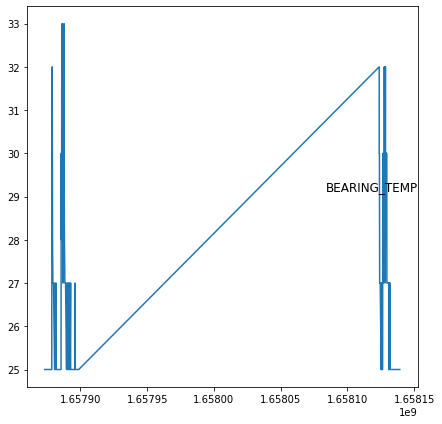

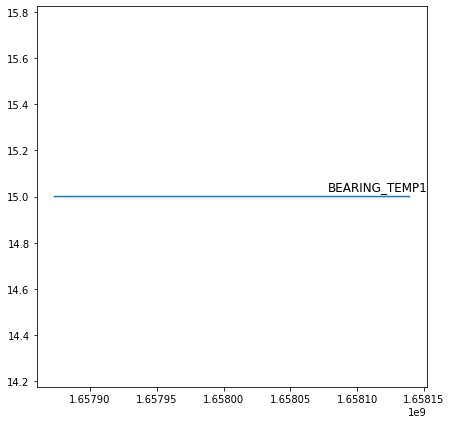

BEARING_TEMP1
La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.


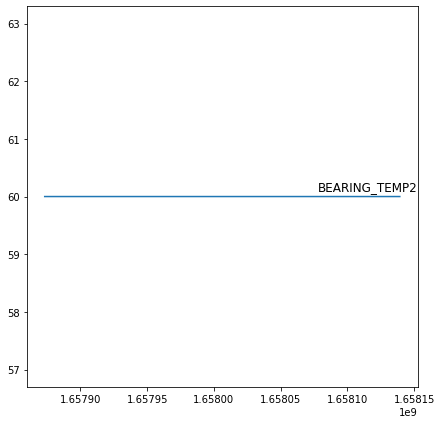

BEARING_TEMP2
La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.


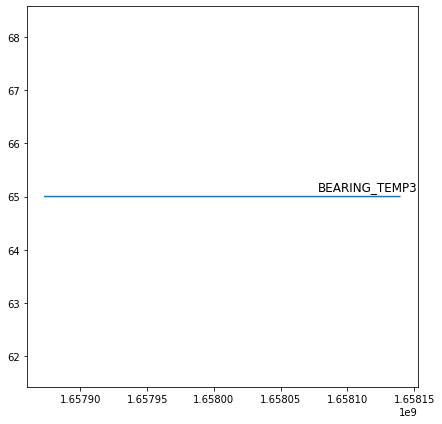

BEARING_TEMP3
La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.


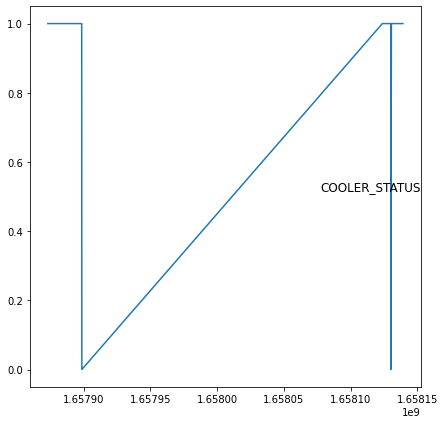

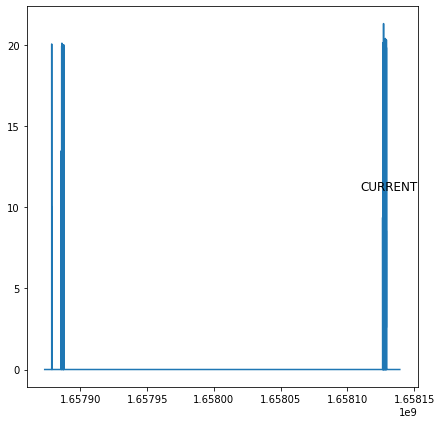

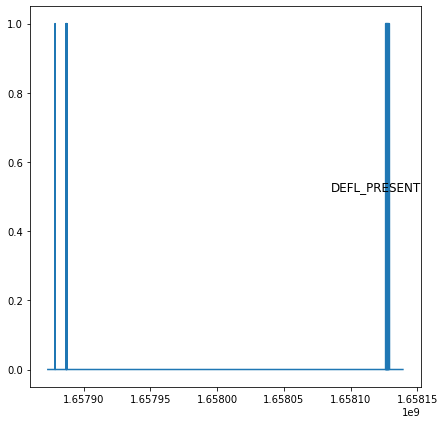

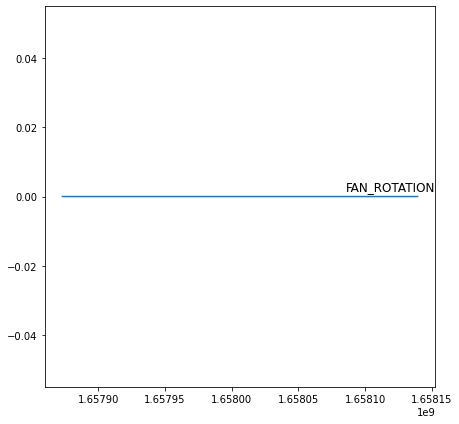

FAN_ROTATION
La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.


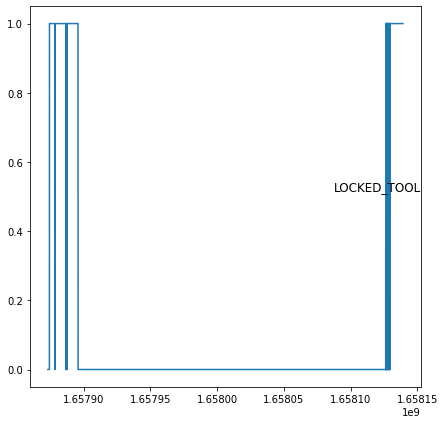

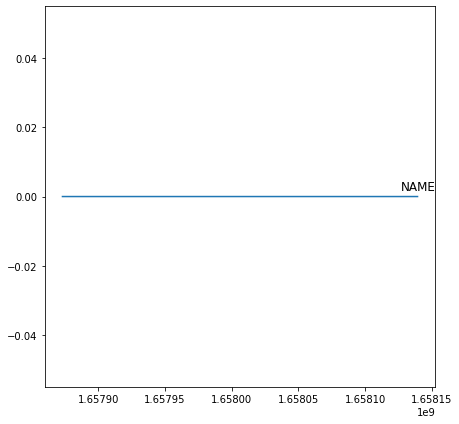

NAME
La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.


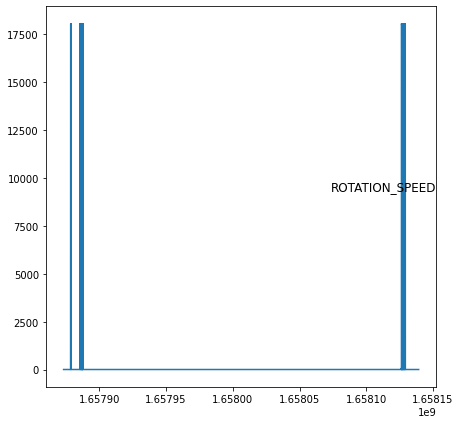

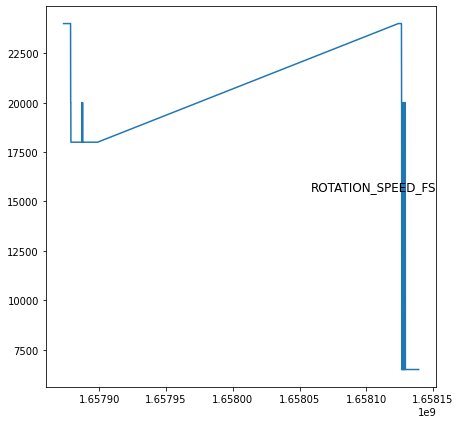

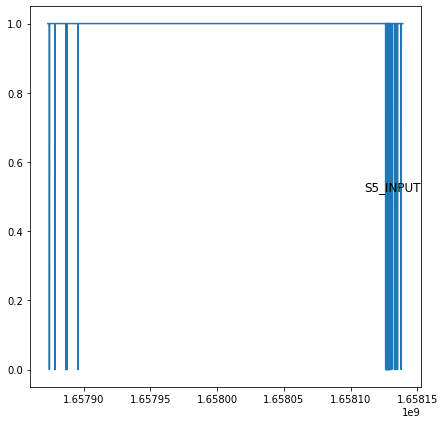

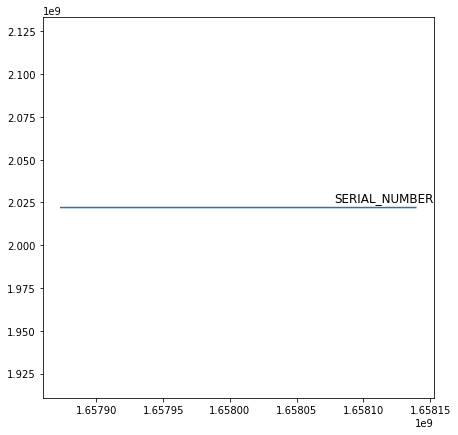

SERIAL_NUMBER
La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.


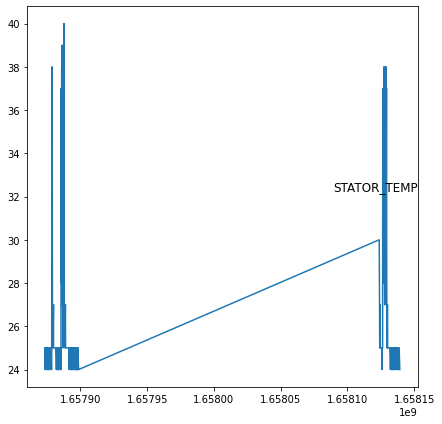

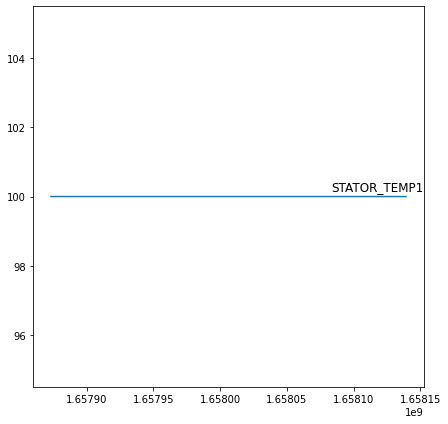

STATOR_TEMP1
La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.


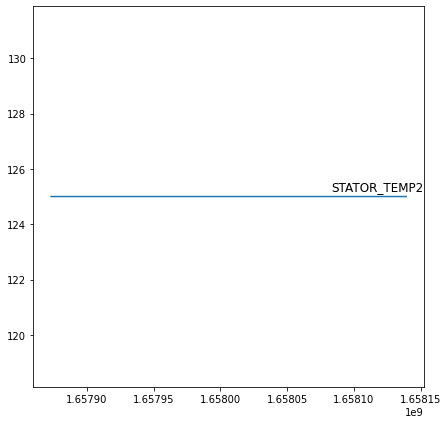

STATOR_TEMP2
La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.


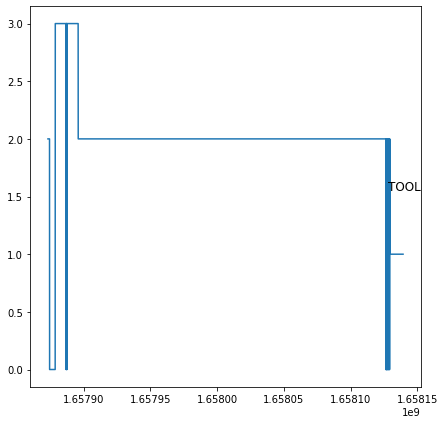

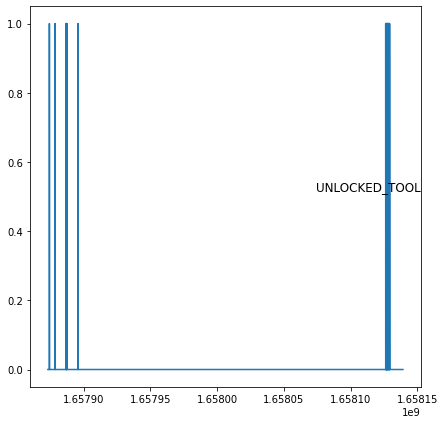

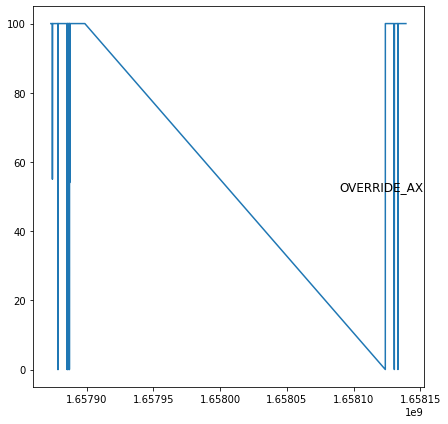

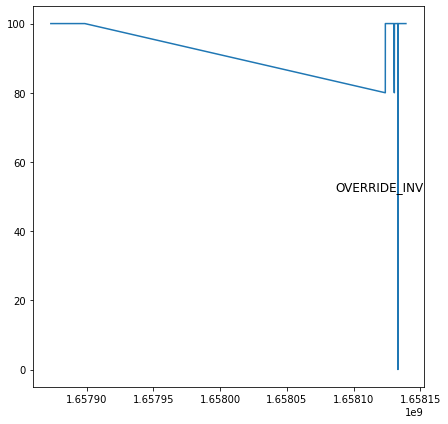

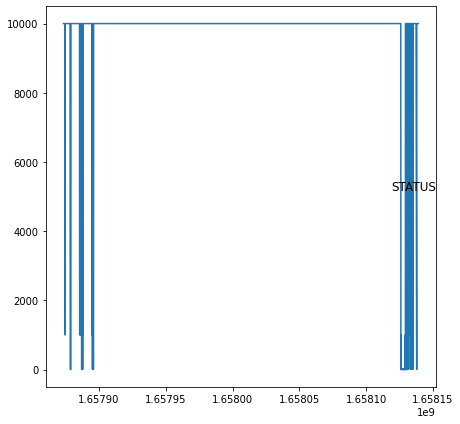

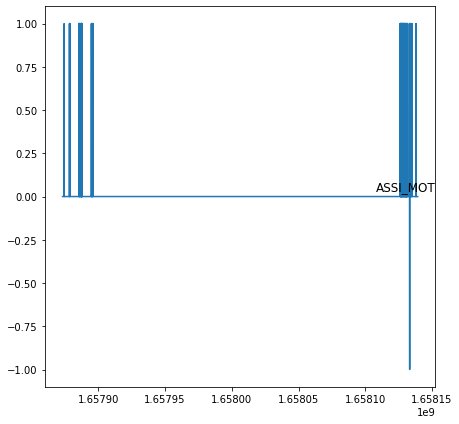

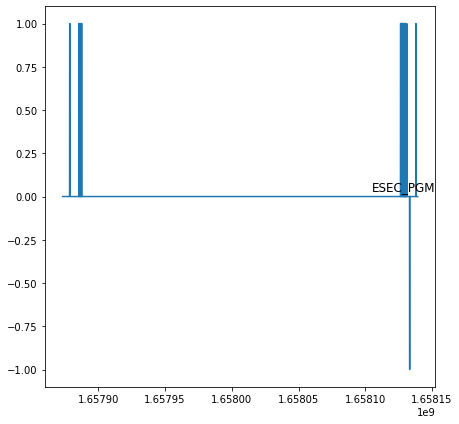

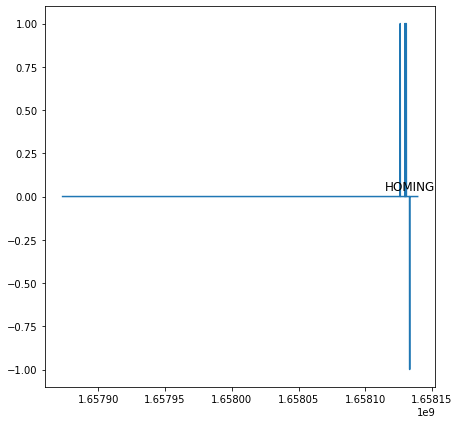

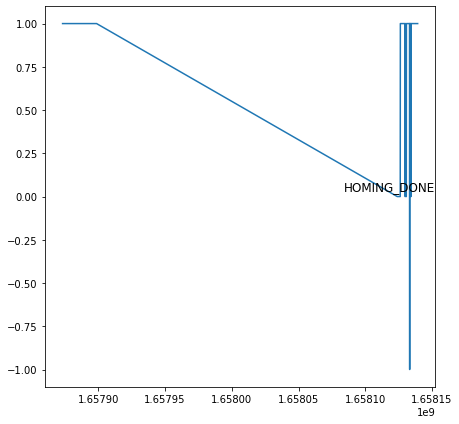

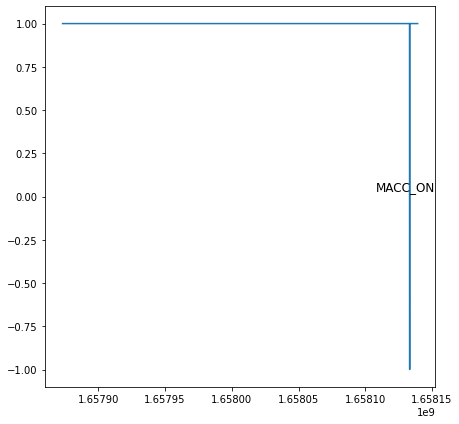

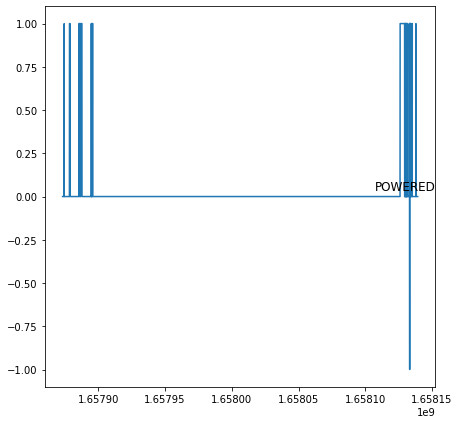

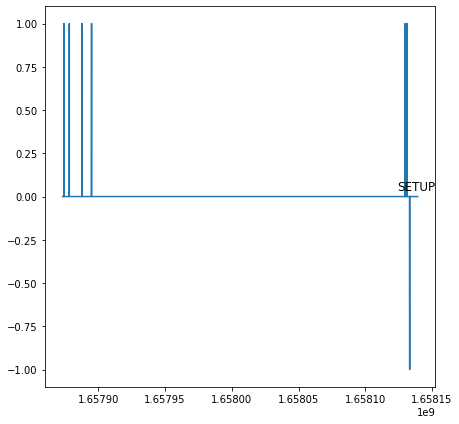

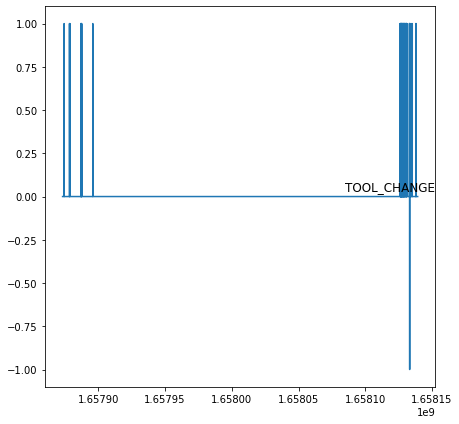

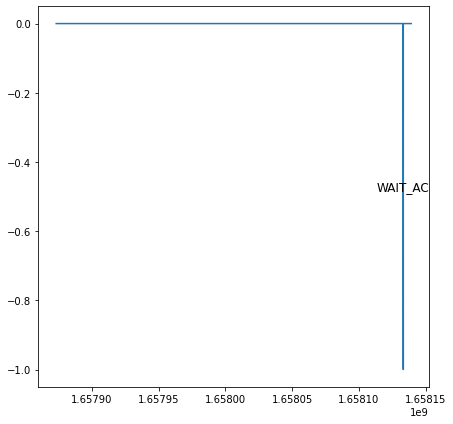

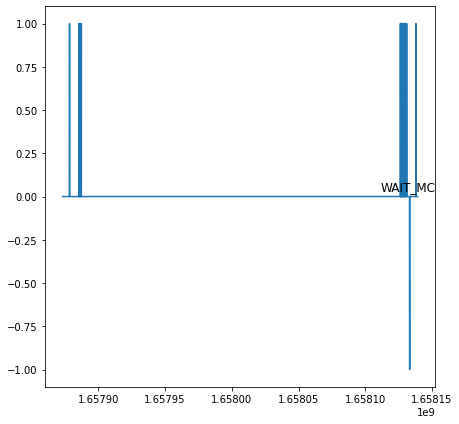

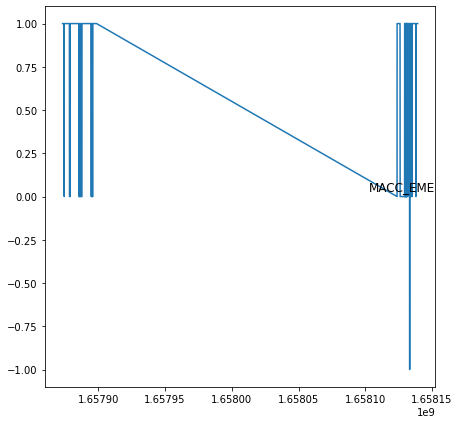

In [82]:
values = dataset.values
# plotto l'andamento nel tempo di ogni feature del dataset
columns = range(len(dataset.columns))
to_drop = list()
for col in columns:
    pyplot.figure(figsize=(7, 7))
    pyplot.plot(dataset.index.values, values[:, col])
    pyplot.title(dataset.columns[col], y=0.5, loc='right')
    pyplot.show()
    if values[:, col].std() == 0.0:
        print(dataset.columns[col])
        print("La feature non da alcuna informazione aggiuntiva, è sempre costante; si può togliere.")
        to_drop.append(col)
dataset.drop(dataset.columns[to_drop], axis=1, inplace=True)
values = dataset.values

In [83]:
# trasformo tutti i valori numerio in float
values = values.astype('float32')
values

array([[25.,  1.,  0., ...,  0.,  0.,  1.],
       [25.,  1.,  0., ...,  0.,  0.,  1.],
       [25.,  1.,  0., ...,  0.,  0.,  1.],
       ...,
       [25.,  1.,  0., ...,  0.,  0.,  1.],
       [25.,  1.,  0., ...,  0.,  0.,  1.],
       [25.,  1.,  0., ...,  0.,  0.,  1.]], dtype=float32)

In [84]:
# normalizzo tutti i dati in modo che siano tutti sullo stesso range
# x = (x - x_min)/(x_max-x_min)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0. , 1. , 0. , ..., 1. , 0.5, 1. ],
       [0. , 1. , 0. , ..., 1. , 0.5, 1. ],
       [0. , 1. , 0. , ..., 1. , 0.5, 1. ],
       ...,
       [0. , 1. , 0. , ..., 1. , 0.5, 1. ],
       [0. , 1. , 0. , ..., 1. , 0.5, 1. ],
       [0. , 1. , 0. , ..., 1. , 0.5, 1. ]], dtype=float32)

In [85]:
N_TIME_STEPS = 1

# trasformo il dataset per un problema supervisionato
reframed = series_to_supervised(scaled, N_TIME_STEPS, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t)
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0625,0.666667,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0000,0.666667,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0625,0.666667,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0000,0.666667,...,0.5,0.5,1.0,1.0,0.5,1.0,0.5,1.0,0.5,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0000,0.666667,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0000,0.333333,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0
2292,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0000,0.333333,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0
2293,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0625,0.333333,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0
2294,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0000,0.333333,...,0.5,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0


In [86]:
# se si è scelto come timestemp temporale 1, ovvero prendere in considerazione 1 record precedente
# allora devo droppare tutte le feature di cui non mi interessa fare predizione
# NOTA: non funziona se N_TIME_STEPS > 1; in questo caso lasciare così
if N_TIME_STEPS == 1:
    lista = list(range(len(reframed.columns) - len(dataset.columns), len(reframed.columns) - 1))
    reframed.drop(reframed.columns[lista], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var25(t)
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0625,0.666667,...,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0000,0.666667,...,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0625,0.666667,...,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0000,0.666667,...,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0000,0.666667,...,0.5,1.0,1.0,0.5,1.0,0.5,1.0,0.5,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0000,0.333333,...,0.5,1.0,1.0,1.0,0.5,0.5,1.0,0.5,0.5,1.0
2292,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0000,0.333333,...,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0,1.0
2293,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0625,0.333333,...,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0,1.0
2294,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0000,0.333333,...,0.5,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0,1.0


In [87]:
values = reframed.values
n_train_hours = len(reframed) - int(len(reframed) * 0.05)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
if N_TIME_STEPS == 1:
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
else:
    train_X, train_y = train[:, :len(dataset.columns) * N_TIME_STEPS], train[:, -1]
    test_X, test_y = test[:, :len(dataset.columns) * N_TIME_STEPS], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], N_TIME_STEPS, len(dataset.columns)))
    test_X = test_X.reshape((test_X.shape[0], N_TIME_STEPS, len(dataset.columns)))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2179, 1, 25) (2179,) (114, 1, 25) (114,)


Epoch 1/100
31/31 [==============================] - 2s 11ms/step - loss: 0.2776 - accuracy: 0.0239 - val_loss: 0.0582 - val_accuracy: 0.2632
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.0730 - val_loss: 0.0597 - val_accuracy: 0.2544
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0599 - accuracy: 0.0684 - val_loss: 0.0448 - val_accuracy: 0.2632
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0462 - accuracy: 0.0863 - val_loss: 0.0391 - val_accuracy: 0.2632
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0387 - accuracy: 0.0982 - val_loss: 0.0340 - val_accuracy: 0.2632
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0338 - accuracy: 0.0978 - val_loss: 0.0301 - val_accuracy: 0.2632
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0278 - accuracy: 0.1101 - val_loss: 0.0274 - val_accuracy: 0.2632
Epoch 8/100


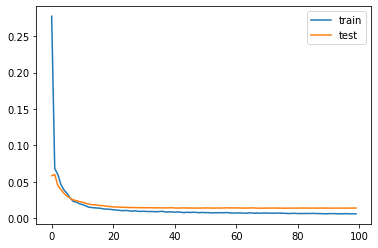

In [88]:
# design network
model = Sequential()
model.add(GRU(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [89]:
yhat = model.predict(test_X)
if N_TIME_STEPS == 1:
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    # invert scaling for actual
    test_y_reshaped = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
else:
    test_X_reshaped = test_X.reshape((test_X.shape[0], len(dataset.columns) * N_TIME_STEPS))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X_reshaped[:, -(len(dataset.columns) - 1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    # invert scaling for actual
    test_y_reshaped = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, -(len(dataset.columns) - 1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

4/4 [==============================] - 0s 5ms/step
Test RMSE: 0.938
